In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, List, Callable
import time

In [20]:
def analytical_solution(x: float, y: float) -> float:
    """Аналитическое решение u(x,y) = exp(x) * cos(y)"""
    return math.exp(x) * math.cos(y)

def left_boundary(y: float) -> float:
    """Левая граница: u(0, y) = cos(y)"""
    return math.cos(y)

def right_boundary(y: float) -> float:
    """Правая граница: u(1, y) = e * cos(y)"""
    return math.exp(1.0) * math.cos(y)

def max_abs_error(A: np.ndarray, B: np.ndarray) -> float:
    """Максимальная абсолютная погрешность"""
    return np.abs(A - B).max()

def mean_abs_error(A: np.ndarray, B: np.ndarray) -> float:
    """Средняя абсолютная погрешность"""
    return np.abs(A - B).mean()

def l2_error(A: np.ndarray, B: np.ndarray) -> float:
    """L2 норма ошибки"""
    return np.sqrt(np.mean((A - B)**2))

In [21]:
def jacobi_method(x_begin: float, x_end: float, y_begin: float, y_end: float,
                 hx: float, hy: float, epsilon: float = 1e-6,
                 max_iter: int = 10000) -> Tuple[np.ndarray, int]:
    """
    Метод простых итераций (Якоби/Либмана)
    """
    nx = int((x_end - x_begin) / hx) + 1
    ny = int((y_end - y_begin) / hy) + 1

    x = np.linspace(x_begin, x_end, nx)
    y = np.linspace(y_begin, y_end, ny)

    # Инициализация решения
    u = np.zeros((nx, ny))

    # Граничные условия Дирихле
    for j in range(ny):
        u[0, j] = left_boundary(y[j])      # левая граница
        u[-1, j] = right_boundary(y[j])    # правая граница

    # Начальное приближение (линейная интерполяция)
    for i in range(1, nx-1):
        for j in range(ny):
            u[i, j] = u[0, j] + (u[-1, j] - u[0, j]) * x[i]

    # Коэффициенты для разностной схемы
    coeff_x = hy**2 / (2 * (hx**2 + hy**2))
    coeff_y = hx**2 / (2 * (hx**2 + hy**2))

    iteration = 0
    error = 1.0

    while error > epsilon and iteration < max_iter:
        u_old = u.copy()

        # Обновление внутренних точек
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u[i, j] = coeff_x * (u_old[i-1, j] + u_old[i+1, j]) + \
                          coeff_y * (u_old[i, j-1] + u_old[i, j+1])

        # Вычисление ошибки (максимальное изменение)
        error = np.max(np.abs(u - u_old))
        iteration += 1

        if iteration % 1000 == 0:
            print(f"  Итерация {iteration}, ошибка: {error:.2e}")

    return u, iteration

def seidel_method(x_begin: float, x_end: float, y_begin: float, y_end: float,
                  hx: float, hy: float, epsilon: float = 1e-6,
                  max_iter: int = 10000) -> Tuple[np.ndarray, int]:
    """
    Метод Зейделя
    """
    nx = int((x_end - x_begin) / hx) + 1
    ny = int((y_end - y_begin) / hy) + 1

    x = np.linspace(x_begin, x_end, nx)
    y = np.linspace(y_begin, y_end, ny)

    # Инициализация решения
    u = np.zeros((nx, ny))

    # Граничные условия Дирихле
    for j in range(ny):
        u[0, j] = left_boundary(y[j])      # левая граница
        u[-1, j] = right_boundary(y[j])    # правая граница

    # Начальное приближение (линейная интерполяция)
    for i in range(1, nx-1):
        for j in range(ny):
            u[i, j] = u[0, j] + (u[-1, j] - u[0, j]) * x[i]

    # Коэффициенты для разностной схемы
    coeff_x = hy**2 / (2 * (hx**2 + hy**2))
    coeff_y = hx**2 / (2 * (hx**2 + hy**2))

    iteration = 0
    error = 1.0

    while error > epsilon and iteration < max_iter:
        error = 0.0

        for i in range(1, nx-1):
            for j in range(1, ny-1):
                old_value = u[i, j]
                u[i, j] = coeff_x * (u[i-1, j] + u[i+1, j]) + \
                          coeff_y * (u[i, j-1] + u[i, j+1])

                # Следим за максимальным изменением
                error = max(error, abs(u[i, j] - old_value))

        iteration += 1

        if iteration % 500 == 0:
            print(f"  Итерация {iteration}, ошибка: {error:.2e}")

    return u, iteration

def sor_method(x_begin: float, x_end: float, y_begin: float, y_end: float,
               hx: float, hy: float, omega: float = 1.5,
               epsilon: float = 1e-6, max_iter: int = 10000) -> Tuple[np.ndarray, int]:
    """
    Метод верхней релаксации (SOR)
    """
    nx = int((x_end - x_begin) / hx) + 1
    ny = int((y_end - y_begin) / hy) + 1

    x = np.linspace(x_begin, x_end, nx)
    y = np.linspace(y_begin, y_end, ny)

    # Инициализация решения
    u = np.zeros((nx, ny))

    # Граничные условия Дирихле
    for j in range(ny):
        u[0, j] = left_boundary(y[j])      # левая граница
        u[-1, j] = right_boundary(y[j])    # правая граница

    # Начальное приближение (линейная интерполяция)
    for i in range(1, nx-1):
        for j in range(ny):
            u[i, j] = u[0, j] + (u[-1, j] - u[0, j]) * x[i]

    # Коэффициенты для разностной схемы
    coeff_x = hy**2 / (2 * (hx**2 + hy**2))
    coeff_y = hx**2 / (2 * (hx**2 + hy**2))

    iteration = 0
    error = 1.0

    while error > epsilon and iteration < max_iter:
        error = 0.0

        for i in range(1, nx-1):
            for j in range(1, ny-1):
                old_value = u[i, j]
                new_value = coeff_x * (u[i-1, j] + u[i+1, j]) + \
                           coeff_y * (u[i, j-1] + u[i, j+1])

                # Применение релаксации
                u[i, j] = old_value + omega * (new_value - old_value)

                # Следим за максимальным изменением
                error = max(error, abs(u[i, j] - old_value))

        iteration += 1

        if iteration % 200 == 0:
            print(f"  Итерация {iteration}, ошибка: {error:.2e}")

    return u, iteration

In [22]:
def plot_solutions(solutions: dict, cur_y: float,
                   x_range: Tuple[float, float], y_range: Tuple[float, float],
                   hx: float, hy: float):
    """
    График решений при фиксированном y
    """
    x_begin, x_end = x_range
    y_begin, y_end = y_range

    x = np.arange(x_begin, x_end + hx/2, hx)
    y = np.arange(y_begin, y_end + hy/2, hy)

    # Находим индекс ближайшего значения y
    cur_y_id = np.abs(y - cur_y).argmin()
    actual_y = y[cur_y_id]

    plt.figure(figsize=(15, 9))

    for method_name, solution in solutions.items():
        plt.plot(x, solution[:, cur_y_id],
                linewidth=2, label=method_name)

    plt.xlabel('x', fontsize=12)
    plt.ylabel('u(x, y)', fontsize=12)
    plt.title(f'Сравнение решений при y = {actual_y:.3f}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_3d_solution(solution: np.ndarray, x_begin: float, x_end: float,
                     y_begin: float, y_end: float, title: str = ""):
    """
    3D визуализация решения
    """
    nx, ny = solution.shape
    x = np.linspace(x_begin, x_end, nx)
    y = np.linspace(y_begin, y_end, ny)
    X, Y = np.meshgrid(x, y)
    Z = solution.T  # Транспонируем для правильной ориентации

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                          alpha=0.8, linewidth=0, antialiased=True)

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_zlabel('u(x, y)', fontsize=12)
    ax.set_title(title, fontsize=14)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

def plot_error_comparison(analytical: np.ndarray,
                         numerical: np.ndarray,
                         x_begin: float, x_end: float,
                         y_begin: float, y_end: float,
                         method_name: str):
    """
    Визуализация ошибки численного решения
    """
    nx, ny = analytical.shape
    x = np.linspace(x_begin, x_end, nx)
    y = np.linspace(y_begin, y_end, ny)
    X, Y = np.meshgrid(x, y)

    # Абсолютная ошибка
    error = np.abs(analytical - numerical).T

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # График ошибки по x при фиксированном y
    ax1 = axes[0]
    y_mid = ny // 2
    ax1.plot(x, error[y_mid, :], linewidth=2)
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('Абсолютная ошибка', fontsize=12)
    ax1.set_title(f'Ошибка при y = {y[y_mid]:.3f}', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # График ошибки по y при фиксированном x
    ax2 = axes[1]
    x_mid = nx // 2
    ax2.plot(y, error[:, x_mid], linewidth=2, color='red')
    ax2.set_xlabel('y', fontsize=12)
    ax2.set_ylabel('Абсолютная ошибка', fontsize=12)
    ax2.set_title(f'Ошибка при x = {x[x_mid]:.3f}', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Анализ ошибок метода {method_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [23]:
def convergence_study(x_begin: float, x_end: float,
                     y_begin: float, y_end: float,
                     h_values: List[float],
                     epsilon: float = 1e-6):
    """
    Исследование сходимости при разных шагах сетки
    """
    errors_jacobi = []
    errors_seidel = []
    errors_sor = []
    iterations_jacobi = []
    iterations_seidel = []
    iterations_sor = []

    print("Исследование сходимости по h:")
    print("=" * 60)

    for h in h_values:
        print(f"\nШаг h = {h}:")
        print("-" * 40)

        # Метод Якоби
        print("Метод Якоби:")
        start_time = time.time()
        sol_jacobi, iter_jacobi, _ = jacobi_method(
            x_begin, x_end, y_begin, y_end, h, h, epsilon
        )
        jacobi_time = time.time() - start_time

        # Метод Зейделя
        print("Метод Зейделя:")
        start_time = time.time()
        sol_seidel, iter_seidel, _ = seidel_method(
            x_begin, x_end, y_begin, y_end, h, h, epsilon
        )
        seidel_time = time.time() - start_time

        # Метод SOR
        print("Метод SOR (ω=1.5):")
        start_time = time.time()
        sol_sor, iter_sor, _ = sor_method(
            x_begin, x_end, y_begin, y_end, h, h, 1.5, epsilon
        )
        sor_time = time.time() - start_time

        # Аналитическое решение на этой сетке
        nx = int((x_end - x_begin) / h) + 1
        ny = int((y_end - y_begin) / h) + 1
        x = np.linspace(x_begin, x_end, nx)
        y = np.linspace(y_begin, y_end, ny)

        analytical = np.zeros((nx, ny))
        for i in range(nx):
            for j in range(ny):
                analytical[i, j] = analytical_solution(x[i], y[j])

        # Вычисление ошибок
        error_j = max_abs_error(sol_jacobi, analytical)
        error_s = max_abs_error(sol_seidel, analytical)
        error_so = max_abs_error(sol_sor, analytical)

        errors_jacobi.append(error_j)
        errors_seidel.append(error_s)
        errors_sor.append(error_so)

        iterations_jacobi.append(iter_jacobi)
        iterations_seidel.append(iter_seidel)
        iterations_sor.append(iter_sor)

        print(f"  Погрешности: Якоби={error_j:.2e}, "
              f"Зейделя={error_s:.2e}, SOR={error_so:.2e}")
        print(f"  Итерации: Якоби={iter_jacobi}, "
              f"Зейделя={iter_seidel}, SOR={iter_sor}")
        print(f"  Время: Якоби={jacobi_time:.3f}с, "
              f"Зейделя={seidel_time:.3f}с, SOR={sor_time:.3f}с")

    # Графики сходимости
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # График 1: Погрешность vs шаг
    ax1 = axes[0]
    ax1.loglog(h_values, errors_jacobi, 'ro-',
              linewidth=2, markersize=8, label='Якоби')
    ax1.loglog(h_values, errors_seidel, 'bs-',
              linewidth=2, markersize=8, label='Зейделя')
    ax1.loglog(h_values, errors_sor, 'g^-',
              linewidth=2, markersize=8, label='SOR')
    ax1.loglog(h_values, h_values, 'k--', alpha=0.5, label='O(h)')
    ax1.loglog(h_values, [h**2 for h in h_values], 'k:',
              alpha=0.5, label='O(h²)')
    ax1.set_xlabel('Шаг сетки h', fontsize=12)
    ax1.set_ylabel('Максимальная погрешность', fontsize=12)
    ax1.set_title('Зависимость погрешности от шага сетки', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # График 2: Число итераций
    ax2 = axes[1]
    ax2.plot(h_values, iterations_jacobi, 'ro-',
            linewidth=2, markersize=8, label='Якоби')
    ax2.plot(h_values, iterations_seidel, 'bs-',
            linewidth=2, markersize=8, label='Зейделя')
    ax2.plot(h_values, iterations_sor, 'g^-',
            linewidth=2, markersize=8, label='SOR')
    ax2.set_xlabel('Шаг сетки h', fontsize=12)
    ax2.set_ylabel('Число итераций', fontsize=12)
    ax2.set_title('Зависимость числа итераций от шага', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # График 3: Порядок сходимости
    ax3 = axes[2]

    # Вычисление порядка сходимости
    orders_jacobi = []
    orders_seidel = []
    orders_sor = []

    for i in range(1, len(h_values)):
        p_j = np.log(errors_jacobi[i-1]/errors_jacobi[i]) / \
              np.log(h_values[i-1]/h_values[i])
        p_s = np.log(errors_seidel[i-1]/errors_seidel[i]) / \
              np.log(h_values[i-1]/h_values[i])
        p_so = np.log(errors_sor[i-1]/errors_sor[i]) / \
               np.log(h_values[i-1]/h_values[i])

        orders_jacobi.append(p_j)
        orders_seidel.append(p_s)
        orders_sor.append(p_so)

    x_pos = np.arange(len(orders_jacobi))
    width = 0.25

    ax3.bar(x_pos - width, orders_jacobi, width,
           label='Якоби', color='red', alpha=0.7)
    ax3.bar(x_pos, orders_seidel, width,
           label='Зейделя', color='blue', alpha=0.7)
    ax3.bar(x_pos + width, orders_sor, width,
           label='SOR', color='green', alpha=0.7)

    ax3.set_xlabel('Переход между сетками', fontsize=12)
    ax3.set_ylabel('Порядок сходимости', fontsize=12)
    ax3.set_title('Порядок сходимости методов', fontsize=14)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f'{h_values[i-1]:.3f}→{h_values[i]:.3f}'
                        for i in range(1, len(h_values))])
    ax3.axhline(y=2, color='k', linestyle='--',
               alpha=0.5, label='Теоретический O(h²)')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Исследование сходимости численных методов',
                fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return (h_values, errors_jacobi, errors_seidel, errors_sor,
            iterations_jacobi, iterations_seidel, iterations_sor)

РЕШЕНИЕ УРАВНЕНИЯ ЛАПЛАСА С ГРАНИЧНЫМИ УСЛОВИЯМИ
Область: x ∈ [0.0, 1.0], y ∈ [0.000, 1.571]
Шаги сетки: hx = 0.01, hy = 0.01
Точность: ε = 1e-06

1. РЕШЕНИЕ МЕТОДОМ ЯКОБИ
--------------------------------------------------
  Итерация 1000, ошибка: 3.81e-05
  Итерация 2000, ошибка: 2.64e-05
  Итерация 3000, ошибка: 1.83e-05
  Итерация 4000, ошибка: 1.28e-05
  Итерация 5000, ошибка: 8.98e-06
  Итерация 6000, ошибка: 6.32e-06
  Итерация 7000, ошибка: 4.45e-06
  Итерация 8000, ошибка: 3.14e-06
  Итерация 9000, ошибка: 2.22e-06
  Итерация 10000, ошибка: 1.57e-06
Итераций: 10000
Время выполнения: 197.648 секунд

2. РЕШЕНИЕ МЕТОДОМ ЗЕЙДЕЛЯ
--------------------------------------------------
  Итерация 500, ошибка: 7.62e-05
  Итерация 1000, ошибка: 5.27e-05
  Итерация 1500, ошибка: 3.66e-05
  Итерация 2000, ошибка: 2.56e-05
  Итерация 2500, ошибка: 1.79e-05
  Итерация 3000, ошибка: 1.26e-05
  Итерация 3500, ошибка: 8.90e-06
  Итерация 4000, ошибка: 6.28e-06
  Итерация 4500, ошибка: 4.43e-06
  И

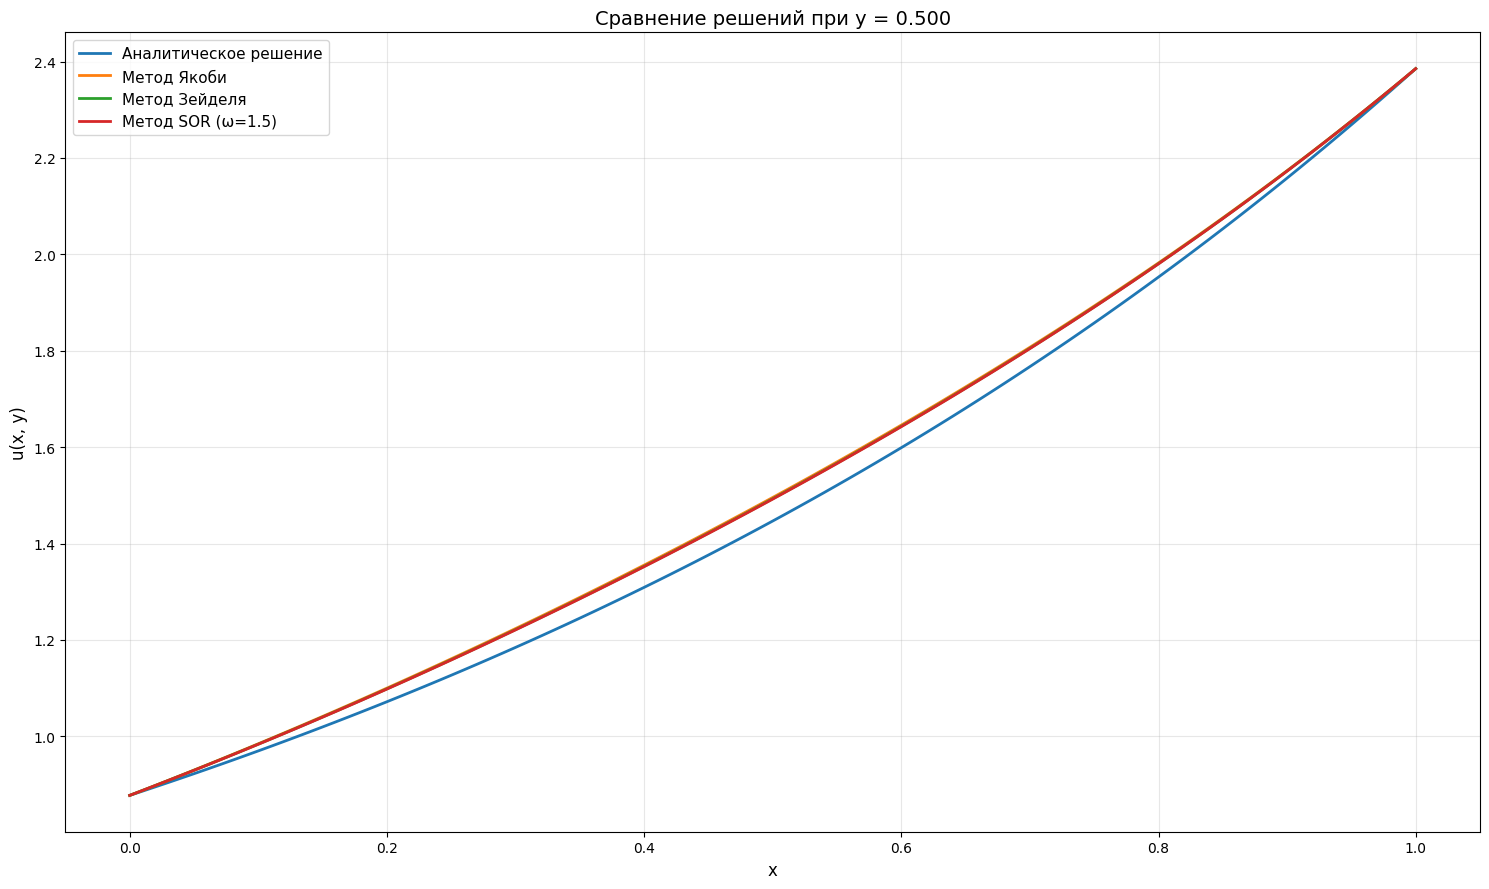


3D визуализация аналитического решения:


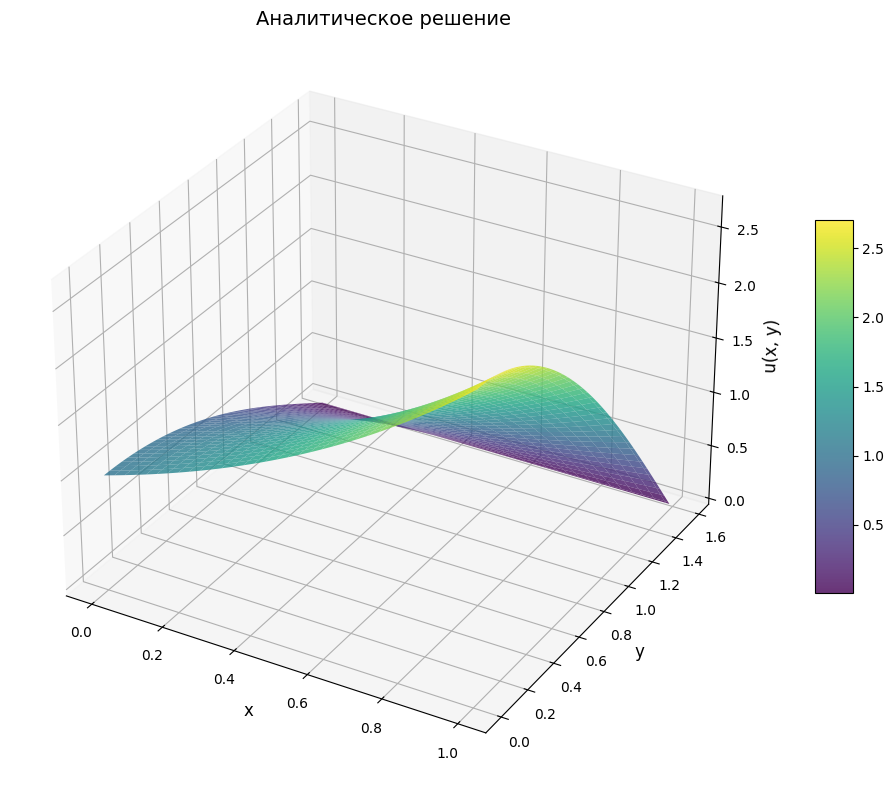


3D визуализация численного решения (метод Якоби):


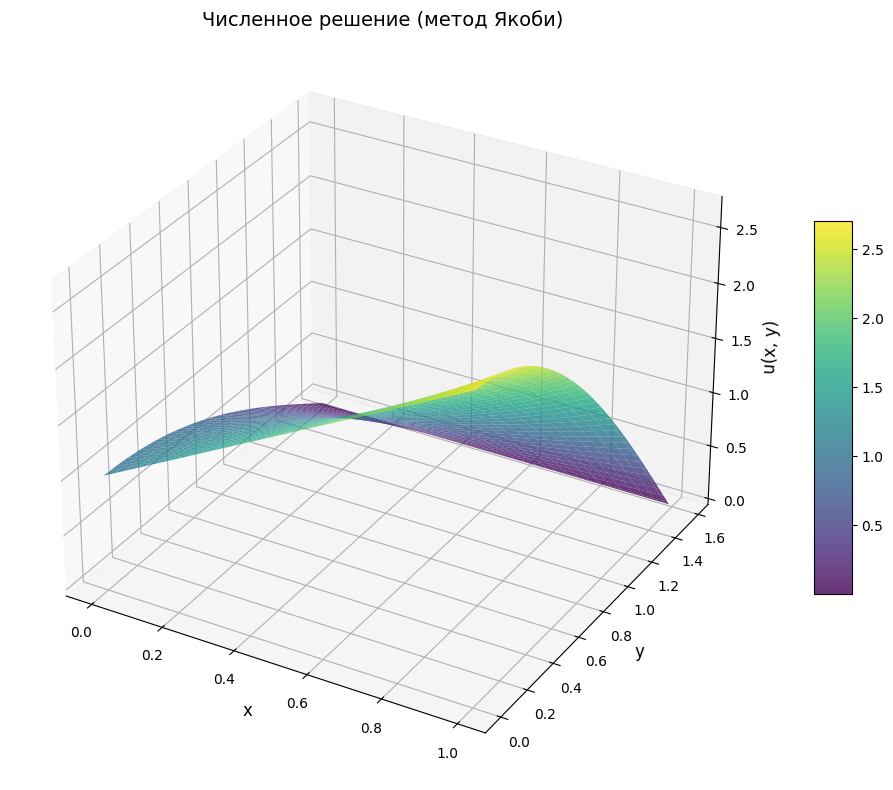


3D визуализация численного решения (метод Зейделя):


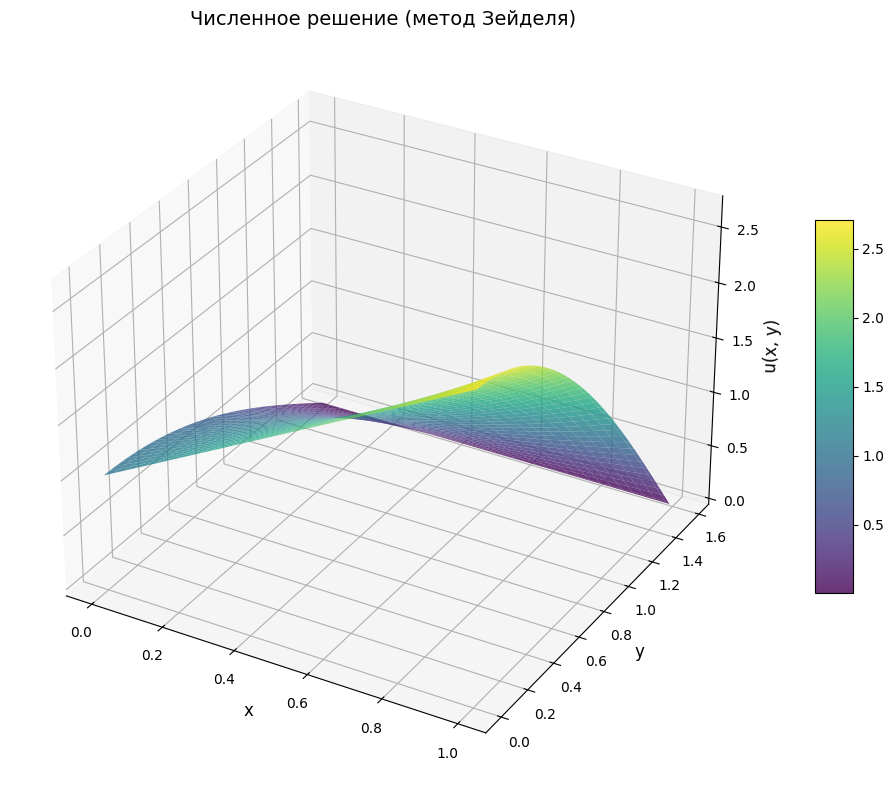


3D визуализация численного решения (метод SOR):


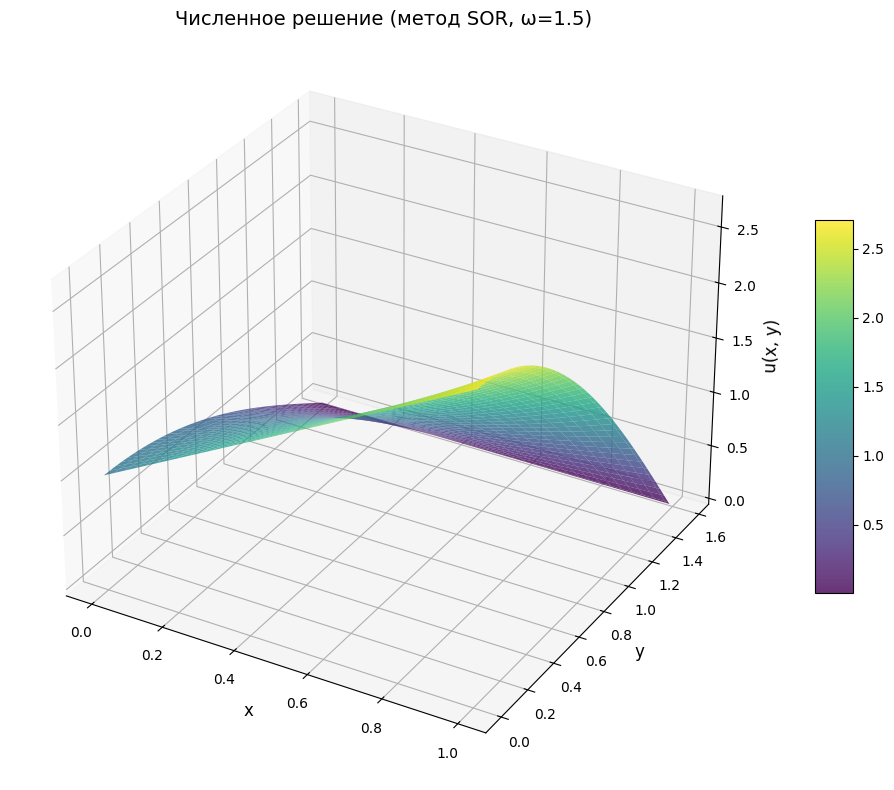


Детальный анализ ошибок:


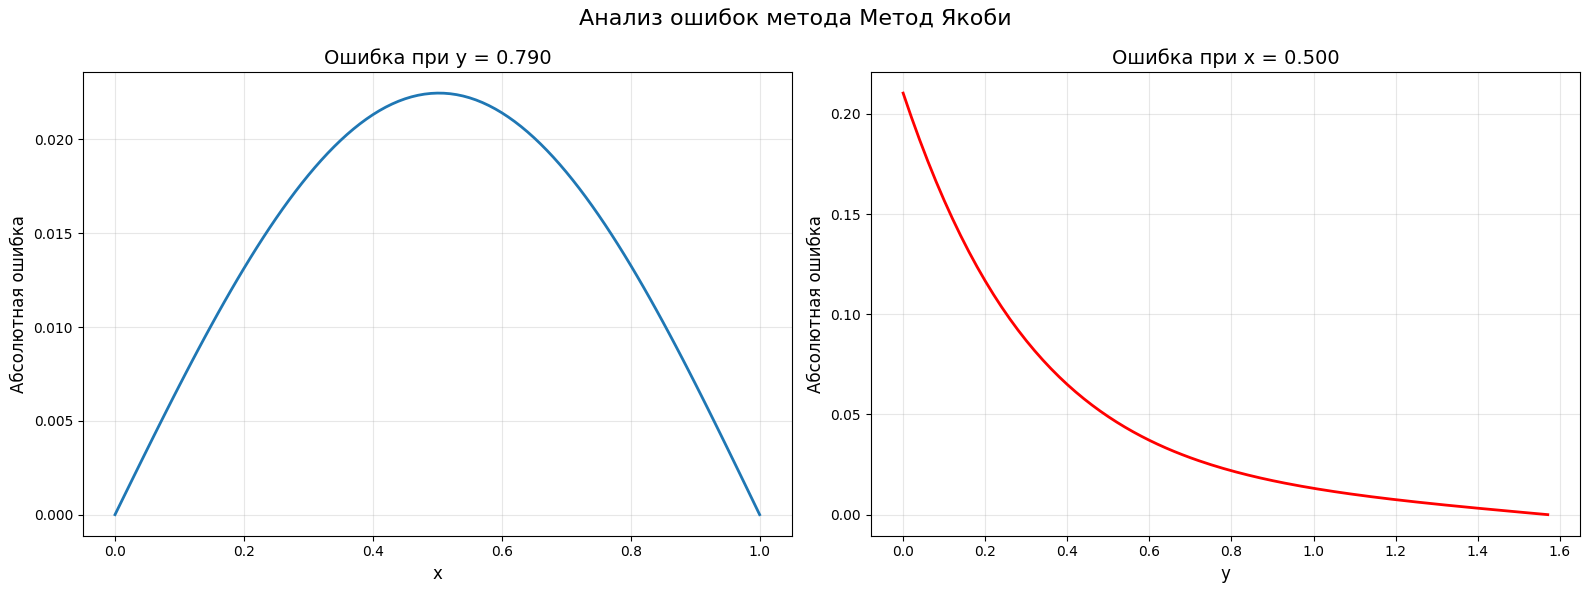

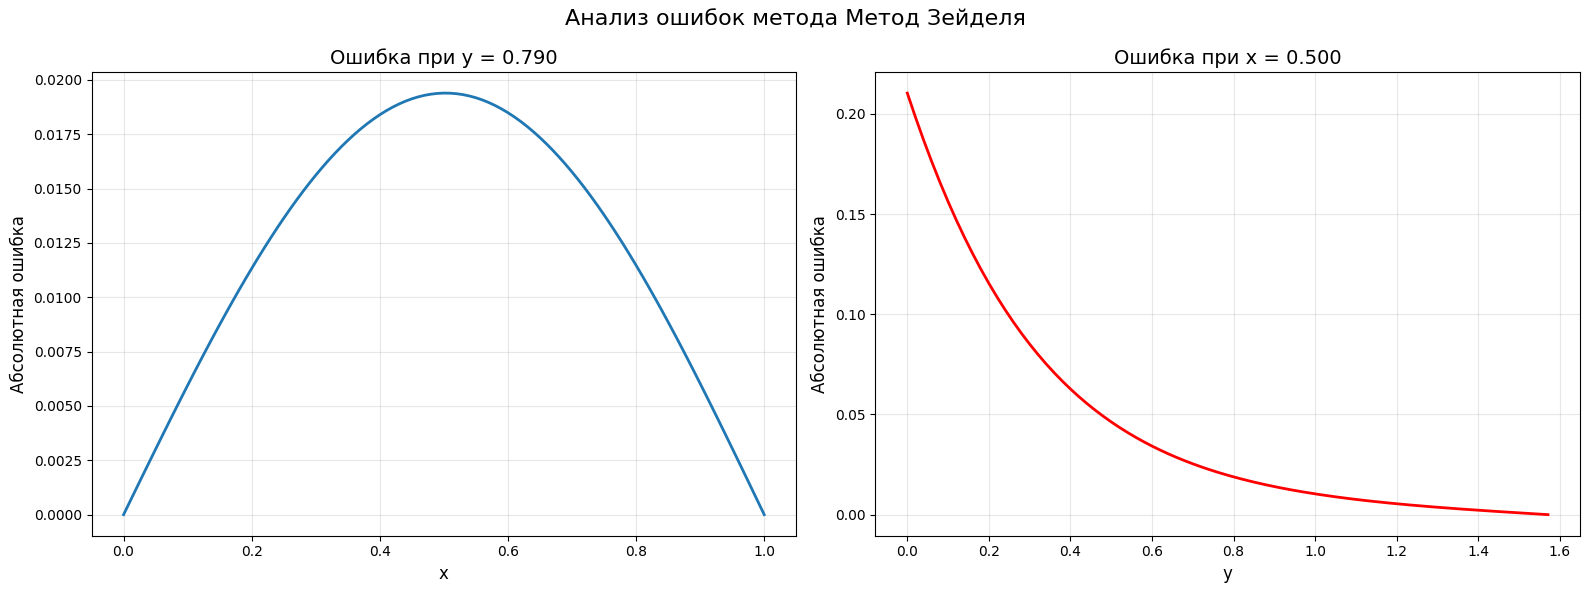

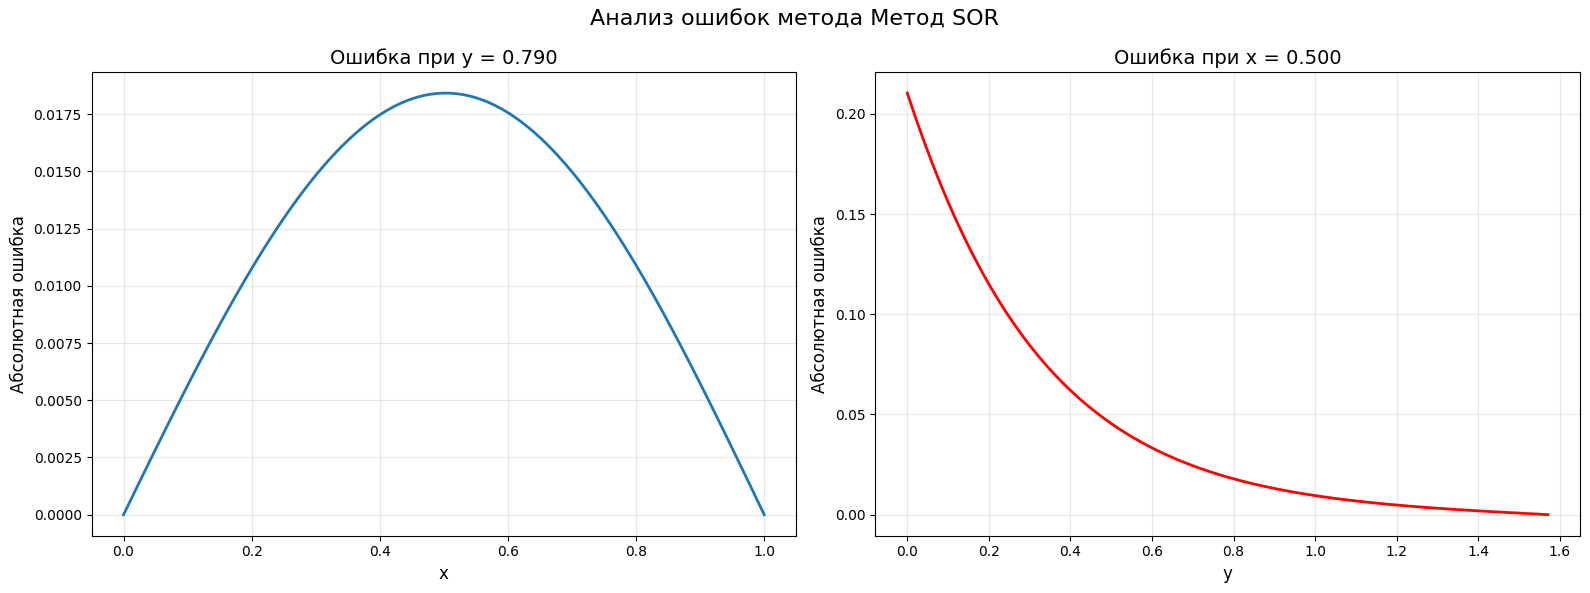


ВЫПОЛНЕНИЕ ЗАВЕРШЕНО


In [24]:
if __name__ == "__main__":
    print("="*70)
    print("РЕШЕНИЕ УРАВНЕНИЯ ЛАПЛАСА С ГРАНИЧНЫМИ УСЛОВИЯМИ")
    print("="*70)

    # Параметры задачи
    x_begin, x_end = 0.0, 1.0
    y_begin, y_end = 0.0, math.pi / 2
    hx, hy = 0.01, 0.01
    epsilon = 1e-6

    print(f"Область: x ∈ [{x_begin}, {x_end}], y ∈ [{y_begin:.3f}, {y_end:.3f}]")
    print(f"Шаги сетки: hx = {hx}, hy = {hy}")
    print(f"Точность: ε = {epsilon}")
    print()

    # 1. РЕШЕНИЕ МЕТОДОМ ЯКОБИ
    print("1. РЕШЕНИЕ МЕТОДОМ ЯКОБИ")
    print("-"*50)

    start_time = time.time()
    solution_jacobi, iter_jacobi = jacobi_method(
        x_begin, x_end, y_begin, y_end, hx, hy, epsilon
    )
    jacobi_time = time.time() - start_time

    print(f"Итераций: {iter_jacobi}")
    print(f"Время выполнения: {jacobi_time:.3f} секунд")

    # 2. РЕШЕНИЕ МЕТОДОМ ЗЕЙДЕЛЯ
    print("\n2. РЕШЕНИЕ МЕТОДОМ ЗЕЙДЕЛЯ")
    print("-"*50)

    start_time = time.time()
    solution_seidel, iter_seidel = seidel_method(
        x_begin, x_end, y_begin, y_end, hx, hy, epsilon
    )
    seidel_time = time.time() - start_time

    print(f"Итераций: {iter_seidel}")
    print(f"Время выполнения: {seidel_time:.3f} секунд")

    # 3. РЕШЕНИЕ МЕТОДОМ ВЕРХНЕЙ РЕЛАКСАЦИИ (SOR)
    print("\n3. РЕШЕНИЕ МЕТОДОМ ВЕРХНЕЙ РЕЛАКСАЦИИ (SOR)")
    print("-"*50)

    omega = 1.5
    start_time = time.time()
    solution_sor, iter_sor = sor_method(
        x_begin, x_end, y_begin, y_end, hx, hy, omega, epsilon
    )
    sor_time = time.time() - start_time

    print(f"Параметр релаксации: ω = {omega}")
    print(f"Итераций: {iter_sor}")
    print(f"Время выполнения: {sor_time:.3f} секунд")

    # 4. АНАЛИТИЧЕСКОЕ РЕШЕНИЕ
    print("\n4. АНАЛИТИЧЕСКОЕ РЕШЕНИЕ")
    print("-"*50)

    nx = int((x_end - x_begin) / hx) + 1
    ny = int((y_end - y_begin) / hy) + 1
    x = np.linspace(x_begin, x_end, nx)
    y = np.linspace(y_begin, y_end, ny)

    analytical = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            analytical[i, j] = analytical_solution(x[i], y[j])

    print(f"Размер сетки: {nx} × {ny}")

    # 5. ВЫЧИСЛЕНИЕ ОШИБОК
    print("\n5. АНАЛИЗ ОШИБОК")
    print("-"*50)

    error_j = max_abs_error(solution_jacobi, analytical)
    error_s = max_abs_error(solution_seidel, analytical)
    error_so = max_abs_error(solution_sor, analytical)

    mean_error_j = mean_abs_error(solution_jacobi, analytical)
    mean_error_s = mean_abs_error(solution_seidel, analytical)
    mean_error_so = mean_abs_error(solution_sor, analytical)

    l2_error_j = l2_error(solution_jacobi, analytical)
    l2_error_s = l2_error(solution_seidel, analytical)
    l2_error_so = l2_error(solution_sor, analytical)

    print("Максимальная абсолютная погрешность:")
    print(f"  Метод Якоби:    {error_j:.6e}")
    print(f"  Метод Зейделя:  {error_s:.6e}")
    print(f"  Метод SOR:      {error_so:.6e}")

    print("\nСредняя абсолютная погрешность:")
    print(f"  Метод Якоби:    {mean_error_j:.6e}")
    print(f"  Метод Зейделя:  {mean_error_s:.6e}")
    print(f"  Метод SOR:      {mean_error_so:.6e}")

    print("\nL2 норма ошибки:")
    print(f"  Метод Якоби:    {l2_error_j:.6e}")
    print(f"  Метод Зейделя:  {l2_error_s:.6e}")
    print(f"  Метод SOR:      {l2_error_so:.6e}")

    # Создаем словарь решений для графиков
    solutions = {
        'Аналитическое решение': analytical,
        'Метод Якоби': solution_jacobi,
        'Метод Зейделя': solution_seidel,
        'Метод SOR (ω=1.5)': solution_sor
    }

    # 6. ГРАФИКИ РЕШЕНИЙ
    print("\n6. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
    print("-"*50)

    # График решений при фиксированном y
    print("\nГрафик решений при фиксированном y = 0.5:")
    plot_solutions(solutions, 0.5, (x_begin, x_end), (y_begin, y_end), hx, hy)

    # 3D визуализации
    print("\n3D визуализация аналитического решения:")
    plot_3d_solution(analytical, x_begin, x_end, y_begin, y_end,
                     "Аналитическое решение")

    print("\n3D визуализация численного решения (метод Якоби):")
    plot_3d_solution(solution_jacobi, x_begin, x_end, y_begin, y_end,
                     "Численное решение (метод Якоби)")

    print("\n3D визуализация численного решения (метод Зейделя):")
    plot_3d_solution(solution_seidel, x_begin, x_end, y_begin, y_end,
                     "Численное решение (метод Зейделя)")

    print("\n3D визуализация численного решения (метод SOR):")
    plot_3d_solution(solution_sor, x_begin, x_end, y_begin, y_end,
                     "Численное решение (метод SOR, ω=1.5)")

    # Детальный анализ ошибок для каждого метода
    print("\nДетальный анализ ошибок:")
    plot_error_comparison(analytical, solution_jacobi,
                         x_begin, x_end, y_begin, y_end,
                         "Метод Якоби")

    plot_error_comparison(analytical, solution_seidel,
                         x_begin, x_end, y_begin, y_end,
                         "Метод Зейделя")

    plot_error_comparison(analytical, solution_sor,
                         x_begin, x_end, y_begin, y_end,
                         "Метод SOR")

    print("\n" + "="*70)
    print("ВЫПОЛНЕНИЕ ЗАВЕРШЕНО")
    print("="*70)